# How to Visualize Differentially Private Datasets in Matplotlib with Antigranular

## Introduction

In March 2024, Oblivious AI held a bootcamp on differential privacy at Oxford University. While attending the event, I got to work on a very interesting problem - preserving individual privacy in web analytics datasets using differential privacy. 

The question was - can a malicious actor find out a person's age group by analyzing their mouse and keyboard tracking data? Specifically, are older people more at risk of a targeted attack if the speed of their typing and mouse movements are exposed?

On the surface, age group itself might seem like a harmless piece of information. However, certain parties can exploit it in several ways such as:

- Targeted scams: Knowing someone's age group can help scammers tailor their approach. For example, they might target older adults with pension scams or younger people with social media phishing attempts.
- Identity theft: Age group can be a puzzle piece in a larger identity theft scheme. Combined with other pieces of information, it could be used to answer security questions or appear more believable when impersonating someone.

So, me and my teammate, Devyani Gauri had an important problem in our hands. First, by running some clustering and classification algorithms on a sample mouse tracking dataset, we conclusively proved that by analyzing mouse movement characteristics (speed, velocity, etc.), we could easily differentiate whether an individual is young or old (through the context of our dataset). 

## Differential privacy refresher

Imagine "Einzelnen" (German for "individual") is in some dataset. Differential privacy aims to make Einzelnen's presence or absence imperceptible to any kind of mathematical analysis. This is achieved by adding controlled noise to the results. 

Let's say we're calculating the average age. Differential privacy guarantees that the final average will be accurate, but with some added noise. This noise ensures Einzelnen's (or anyone else's for that matter) specific age cannot be derived from the final result, even if their data was removed.

The accuracy of calculations in differential privacy is affected by a parameter called epsilon (ε). Lower ε signifies stronger privacy guarantees but with more noise, potentially affecting accuracy. Using too little epsilon can return a useless answer like five times the original result while too much might just give it away. 

Because of such high a degree of privacy guarantee, differential privacy has applications in finance, economics, business, healthcare or any other high-risk domains where even the employees who handle and analyze the data can't be allowed to "peek inside". 

## What is Antigranular?

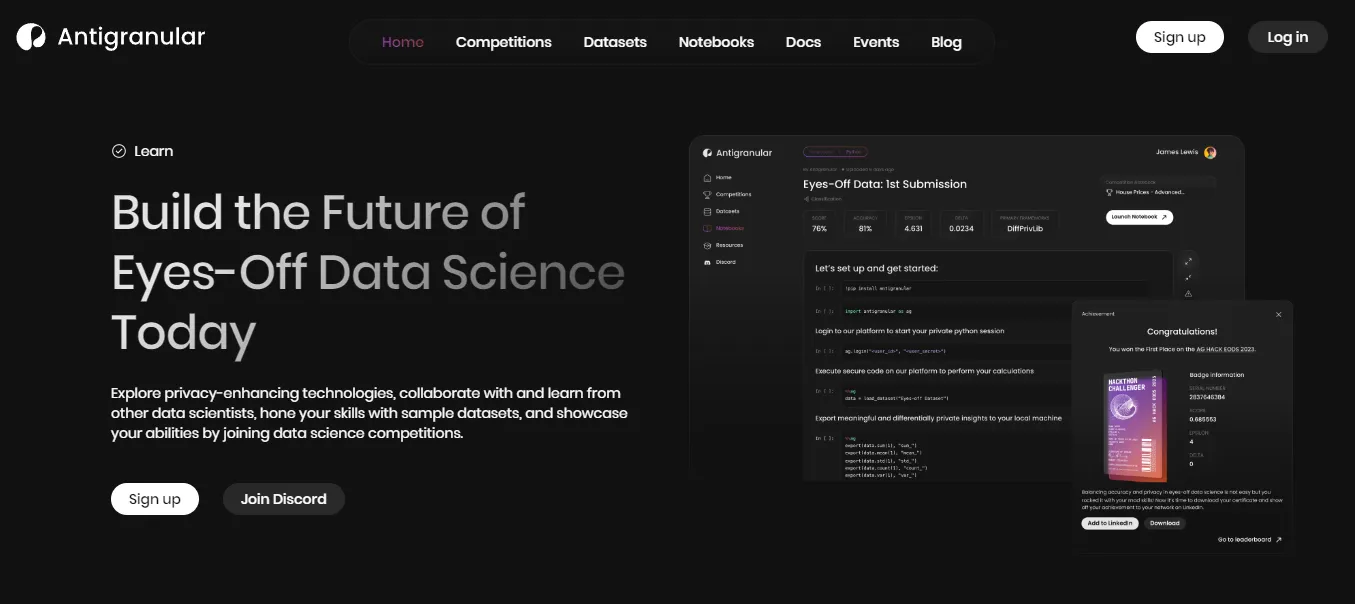

Antigranular (developed by Oblivious) is a secure and trusted platform to host your company data privately or publicly under differential privacy. 

The platform stores data in secure AWS Nitro Enclaves that use cryptographic attestation. Each enclave runs Private Python runtimes, which are special modified versions of Python that only include select functions and libraries designed with differential privacy in mind.

I've written about the AntiGranular platform in detail in these two articles. You can read them here:
- [Antigranular: How to Access Sensitive Datasets Without Looking At Them](https://medium.com/towards-artificial-intelligence/antigranular-how-to-access-sensitive-datasets-without-looking-at-them-44090cb22d8a)
- [How to Explore And Clean Sensitive Data You Can't Even See With Antigranular](https://medium.com/datadriveninvestor/how-to-explore-and-clean-sensitive-data-you-cant-even-see-with-antigranular-14efca3cfcae)

This article addresses the painful data visualization aspect of differential privacy and by extension, the Antigranular platform itself. Since many of the visuals we use in regular data science projects such as scatterplots, histograms, boxplots and so on are prone to privacy attacks, you can't access Matplotlib or any Python plotting library inside Antigranular. 

However, after reading this article, you will be able to use any plotting library or function you want on differentially private datasets. This will be possible by using a novel approach our team came up during the Differential Privacy Bootcamp at Oxford University. 

Let's get started!

## So, how to visualize DP datasets with Matplotlib?

__SETUP__

First off, we will need an open-source dataset and its differentially private version to create the same visuals on both and compare them. Just like many of my other datasets, we will go with the Diamonds dataset from Kaggle which is built into Seaborn and into the Antigranular platform itself.

So, the very first thing to do is for you to create a virtual environment, preferably Conda, and install a few libraries we need:

```bash
$ conda create -n antigranular python==3.9 -y
$ conda activate antigranular
$ pip install antigranular seaborn matplotlib pandas numpy
```

`antigranular` is the official Python interface to interact with the Antigranular platform and its Nitro Enclaves. Next, run the following two commands, please:

```bash
$ pip install ipykernel
$ ipython kernel install --user --name=antigranular
```

The last command will add the `antigranular` virtual environment to your Jupyter as a kernel. And yes, we will be working inside Jupyter notebooks - it is a requirement for Antigranular. 

Then, you can go to [https://www.antigranular.com/](https://www.antigranular.com/) and create your free account. There, you will be able to copy a code snippet with your login credentials to connect to the Nitro Enclave that holds the differentially private Diamonds dataset:

![](images/diamonds.gif)

Run the snippet in a new notebook:

In [20]:
import os

from dotenv import load_dotenv

load_dotenv()  # Hide this block

True

In [21]:
import antigranular as ag

session = ag.login(
    os.getenv("USER_ID"),
    os.getenv("USER_SECRET"),
    dataset="Diamonds Dataset",
)

local_host_port: 55873849-281a-4eba-a61e-beeca0a5d4d6
tls_cert_name: ip-100-100-18-240.eu-west-1.compute.internal_55873849-281a-4eba-a61e-beeca0a5d4d6
cert_thumbprint: d9fb3652636e30241cc2c522ff4be4fab27c6af832798ff41349523c54973d28c5c7f0191e4f7dfe336fa6a89167bff6fde66a743e6f1997476769b256869440
server_hostname: ip-100-100-18-240.eu-west-1.compute.internal
Dataset "Diamonds Dataset" loaded to the kernel as diamonds_dataset
Key Name                       Value Type     
---------------------------------------------
train_x                        PrivateDataFrame
train_y                        PrivateDataFrame
test_x                         DataFrame      

Connected to Antigranular server session id: 83f9433f-4123-44fd-afc6-47ab7d5bd040, the session will time out if idle for 25 minutes
Cell magic '%%ag' registered successfully, use `%%ag` in a notebook cell to execute your python code on Antigranular private python server
🚀 Everything's set up and ready to roll!


Once you run the copied code, you will see two important messages:
- A new object named `diamonds_dataset` has been created that contains `train_X` and `train_y` arrays (more on them later).
- `%%ag` magic command has been registered.

The `%%ag` magic command is a secure bridge that connects your Jupyter notebook to the Nitro Enclave. This means that if you want a cell to be executed using the enclave, you add the `%%ag` code to the top. 

For example, since `diamonds_dataset` is inside the enclave, the below code won't work:

In [17]:
train_x = diamonds_dataset["train_x"]
train_y = diamonds_dataset["train_y"]

print(train_x.columns)

NameError: name 'diamonds_dataset' is not defined

But if you add the `%%ag`, it will work just as expected:

In [22]:
%%ag

train_x = diamonds_dataset["train_x"]
train_y = diamonds_dataset["train_y"]

ag_print(train_x.columns)

['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y', 'z']



> Note: `ag_print` is a differentially private version of Python `print` function. We will be using it a lot today.

From now on, any code cell that uses the `train_x` and `train_y` arrays must have the `%%ag` magic to work. 

By the way, I said that Pandas isn't supported inside AG, so what are `train_x` and `train_y`? Well, they are `PrivateDataFrame` objects which are the same as Pandas DataFrames but with a select differentially private methods:

In [23]:
%%ag

from op_pandas import PrivateDataFrame, PrivateSeries

In [26]:
%%ag

ag_print(train_x.describe(eps=0.5))

              carat         depth  ...             y             z
count  37683.000000  38033.000000  ...  37724.000000  37610.000000
mean       0.798838     61.693000  ...      6.286918      3.444645
std        0.535844      1.144351  ...      6.006865      0.686556
min        0.200000     43.000000  ...      0.000000      0.000000
25%        0.305974     60.833498  ...      5.226899      2.876851
50%        0.636000     61.268247  ...      5.744241      3.238154
75%        1.037326     62.291877  ...      6.574496      3.980006
max        4.075506     72.051737  ...     13.937366     14.679216

[8 rows x 6 columns]



Above, we ran a DP version of `describe` function, which has an `eps` (epsilon) parameter. The more epsilon you spend, the closer the output will be to that of Pandas `.describe()`. To keep the balance between total noise and utility, an epsilon between 0.1 and 1 is usually enough. 

Now, that we have covered the fundamentals, let's move on to the data visualization part. 

## Conclusion